# Modelo predictivo para coches pequeños (`vehicleType` = "small car")

In [248]:
import pandas as pd
import numpy as np

import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from itertools import product

from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder

from category_encoders import TargetEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../..")
from src.support_ml import * 

In [249]:
params_tree = {
    'max_depth': [6, 8, 10, 20],
    'min_samples_split': [10, 50],
    'min_samples_leaf': [10, 50],
    'max_leaf_nodes': [10, 20, 40, 80, 160]
}

In [250]:
df = pd.read_csv("../../datos/autorenew.csv")

In [251]:
df = df[df["vehicleType"] == "small car"]
df.drop(columns = "vehicleType", inplace = True)

## EDA and nulls

Mapa para los valores de los meses.

In [252]:
month_map = {
    0: "unknown",
    1: "january",
    2: "february",
    3: "march",
    4: "april",
    5: "may",
    6: "june",
    7: "july",
    8: "august",
    9: "september",
    10: "october",
    11: "november",
    12: "december"
}

Simlpificamos las fechas y así agrupamos en categóricas con menos valores.

In [253]:
df["dateCreated"] = pd.to_datetime(df["dateCreated"]).apply(lambda x: x.strftime("%Y-%m"))
df["dateCrawled"] = pd.to_datetime(df["dateCrawled"]).apply(lambda x: x.strftime("%Y-%m"))
df["lastSeen"] = pd.to_datetime(df["lastSeen"]).apply(lambda x: x.strftime("%Y-%m"))

Hacemos el proceso mencionado en el paso de tratamiento de nulos (otro notebook). Además también agrupamos los años en grupos más concretos que nos reducirán las categorías de los años.

In [254]:
df.drop(index = df[df["price"]<=250].index, inplace=True)

upper_error_index = df[(df["price"] > 1.7e+05) & (df["powerCV"] < 400)].index
df.drop(index=upper_error_index, inplace=True)

df.drop(index = df[df["price"] > 1e+9].index, inplace=True)

cv_cond = (df["powerCV"] < 50) | (df["powerCV"] > 1000)
df.loc[df[cv_cond].index, "powerCV"] = np.nan

cond_year = (df["yearOfRegistration"] < 1900) | (df["yearOfRegistration"] >= 2017)
df.loc[df[cond_year].index, "yearOfRegistration"] = 'unknown'

coche_year_dicc = {
    "Coche Vintage": list(range(1900, 1946)),
    "Coche Clásico": list(range(1946, 1971)),
    "Coche Retro-Moderno": list(range(1971, 1991)),
    "Coche Moderno": list(range(1991, 2011)),
    "Coche Contemporáneo": list(range(2011, 2025)),
    "unknown" : ["unknown"]
}

year_to_category = {}

for category, years in coche_year_dicc.items():
    for year in years:
        year_to_category[year] = category

df["yearOfRegistration"] = df["yearOfRegistration"].map(year_to_category)


df["monthOfRegistration"] = df["monthOfRegistration"].map(month_map)

for col in df.select_dtypes("O").columns:
    df.loc[df[df[col].isna()].index, col] = 'unknown'

df.reset_index(drop=True, inplace=True)

Imputamos los nulos que se hayan generado en las numéricas.

In [255]:
df_treated = impute_nulls(df)

[IterativeImputer] Completing matrix with shape (73829, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 8.88
[IterativeImputer] Change: 331.3126941483336, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 2/10, elapsed time 19.04
[IterativeImputer] Change: 65.38999999999999, scaled tolerance: 150.0 
[IterativeImputer] Early stopping criterion reached.


In [256]:
df_imputed = df.copy()
df_imputed[df_treated.columns] = df_treated

In [257]:
df_imputed.head()

,dateCrawled,name,seller,offerType,price,abtest,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03,GOLF_4_1_4__3TÜRER,private,offer,1500.0,test,Coche Moderno,manually,74.00,golf,150000.0,june,petrol,volkswagen,no,2016-03,0.0,91074.0,2016-03
1,2016-03,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600.0,test,Coche Moderno,manually,68.00,fabia,90000.0,july,diesel,skoda,no,2016-03,0.0,60437.0,2016-04
2,2016-03,VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...,private,offer,999.0,test,Coche Moderno,manually,100.00,golf,150000.0,unknown,unknown,volkswagen,unknown,2016-03,0.0,27472.0,2016-03
3,2016-03,KA_Lufthansa_Edition_450€_VB,private,offer,450.0,test,Coche Vintage,unknown,57.43,ka,5000.0,unknown,petrol,ford,unknown,2016-03,0.0,24148.0,2016-03
4,2016-03,Renault_Twingo_1.2_16V_Aut.,private,offer,1750.0,control,Coche Moderno,automatic,74.00,twingo,150000.0,february,petrol,renault,no,2016-03,0.0,65599.0,2016-04


Nos deshacemos de aquellas categorías que no vamos a usar, ya que son muy extensas y no nos aportará ninguna información.

In [258]:
df_imputed.drop(columns=['name', 'model', 'postalCode'], inplace=True)

## Encoding

Encodeamos como vemos en el notebook de encoding. Primero las nominales con one hot encoder, y luego las ordinales con target encoder.

In [259]:
onehot_abtest = encode_onehot(df_imputed, columns=["abtest"])
df_noout_onehot = pd.concat([df_imputed.reset_index(drop=True), onehot_abtest.reset_index(drop=True)], axis=1)

In [260]:
df_noout_onehot.drop(columns=["seller", "offerType", "abtest"], inplace=True)
df_noout_onehot.reset_index(drop=True, inplace=True)

In [261]:
df_noout_onehot.select_dtypes('O').columns

Index(['dateCrawled', 'yearOfRegistration', 'gearbox', 'monthOfRegistration',
       'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'lastSeen'],
      dtype='object')

In [269]:
df_encoded = encode_target(df_noout_onehot, columns = df_noout_onehot.select_dtypes('O').columns, response_var="price")

## Outliers

Gestionamos los outliers como en el notebook correspondiente.

In [270]:
df_encoded.drop(columns="nrOfPictures", inplace=True)

In [271]:
numeric_cols = df_encoded.select_dtypes("number").columns.drop(["price", "abtest_control", "abtest_test"])

In [272]:
ifo_outliers = find_outliers(data = df_encoded, columns = numeric_cols, threshold=60)

100%|██████████| 25/25 [01:55<00:00,  4.61s/it]


In [273]:
df_drop_ifo = df_encoded.drop(index = ifo_outliers.index)
df_drop_ifo.reset_index(drop=True, inplace=True)

In [274]:
lof_outliers = find_outliers(data = df_drop_ifo, columns = numeric_cols)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:46<00:00,  4.26s/it]


In [275]:
numeric_cols

Index(['dateCrawled', 'yearOfRegistration', 'gearbox', 'powerCV', 'kilometer',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage',
       'dateCreated', 'lastSeen'],
      dtype='object')

In [276]:
real_numeric_cols = ["powerCV", "kilometer"]

In [277]:
df_drop_ifo.loc[lof_outliers.index, real_numeric_cols] = np.nan

df_lof_imputed = impute_nulls(data = df_drop_ifo)

[IterativeImputer] Completing matrix with shape (69352, 14)
[IterativeImputer] Ending imputation round 1/10, elapsed time 31.96
[IterativeImputer] Change: 99347.20643631561, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 2/10, elapsed time 67.03
[IterativeImputer] Change: 60084.7119, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 3/10, elapsed time 104.73
[IterativeImputer] Change: 54404.3559, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 4/10, elapsed time 142.95
[IterativeImputer] Change: 45453.7746, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 5/10, elapsed time 183.73
[IterativeImputer] Change: 58266.64, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 6/10, elapsed time 223.84
[IterativeImputer] Change: 46405.941966666665, scaled tolerance: 150.0 
[IterativeImputer] Ending imputation round 7/10, elapsed time 265.46
[IterativeImputer] Change: 42054.4633, scaled tolerance: 150.0

In [278]:
df_drop_ifo.loc[lof_outliers.index, numeric_cols] = df_lof_imputed

In [279]:
df_noout = df_drop_ifo

## Feature Scaling

Ahora para la estandarización lo haremos con todas las columnas, ya que han sido procesadas con encoding y ya son numéricas.

In [289]:
df_scaled = scale_data(data =df_noout, columns = numeric_cols, method='standard')

In [290]:
df_imputed_scaled = df_noout.copy()

In [291]:
df_imputed_scaled[df_scaled.columns] = df_scaled

In [292]:
df_imputed_scaled.head(2)

,dateCrawled,price,yearOfRegistration,gearbox,powerCV,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,abtest_control,abtest_test
0,-0.409079,1500.0,-0.291942,-0.180219,0.048223,0.746064,0.410365,-0.139538,-0.075494,0.572844,-0.281078,-1.097411,0.0,1.0
1,-0.409079,3600.0,-0.291942,-0.180219,-0.232685,-0.785705,0.250514,2.999402,1.452261,0.572844,-0.281078,0.911236,0.0,1.0


## Training

Ya pasamos con el entrenamiento del modelo. Creamos una función que nos dará las métricas y unos subplots de la visualización de las predicciones.

In [284]:
def metrics_n_plot(model, X_train, X_test, y_train, y_test):
    y_test_pred_gb = model.predict(X_test)
    y_train_pred_gb = model.predict(X_train)
    plt.subplot(2,2,3)
    plt.plot([0, max(y_test)], [0, max(y_test)], ls = "--", color = "red")
    sns.scatterplot(x = y_test, y = y_test_pred_gb)
    plt.title("Test")
    plt.subplot(2,2,4)
    sns.scatterplot(x = y_test, y = y_test-y_test_pred_gb)
    plt.axhline(y = 0, ls = "--", color = "red")
    plt.title("Test")
    plt.subplot(2,2,1)
    plt.plot([0, max(y_train)], [0, max(y_train)], ls = "--", color = "red")
    sns.scatterplot(x = y_train, y = y_train_pred_gb)
    plt.title("Train")
    plt.subplot(2,2,2)
    sns.scatterplot(x = y_train, y = y_train-y_train_pred_gb)
    plt.axhline(y = 0, ls = "--", color = "red")
    plt.title("Train")
    plt.tight_layout()
    plt.show()
    return get_metrics(y_train, y_train_pred_gb, y_test, y_test_pred_gb)

In [285]:
df_imputed_scaled.columns

Index(['dateCrawled', 'price', 'yearOfRegistration', 'gearbox', 'powerCV',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'lastSeen', 'abtest_control',
       'abtest_test'],
      dtype='object')

Separamos en X e y, según las variables predictoras y respuesta.

In [293]:
X = df_imputed_scaled.drop(columns= ["price"])
y = df_imputed_scaled["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Después de varias iteraciones, damos con unas que nos permiten tener unos mejores resultados.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 12, 'max_leaf_nodes': 70, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 130}


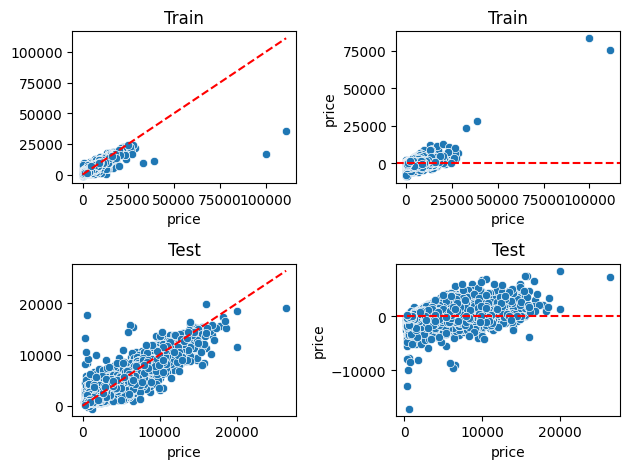

,r2_score,MAE,MSE,RMSE
train,0.837293,696.810392,1.214760e+06,1102.161501
test,0.828779,754.435589,1.212990e+06,1101.358176


In [303]:
params_gb = {'n_estimators': [120,130],
            'max_depth': [8, 10, 12],
            'min_samples_split': [6,7,9],
            'min_samples_leaf': [7, 8],
            'max_leaf_nodes': [70,80,90]}

grid_search_gb = create_model(params=params_gb, X_train=X_train, y_train=y_train, method = GradientBoostingRegressor(random_state=42, learning_rate=0.1), cv = 5)
gb_estimator = grid_search_gb.best_estimator_
print(grid_search_gb.best_params_)
metrics_n_plot(gb_estimator, X_train, X_test, y_train, y_test)

Vemos un $r^2$ de 0.82 y unos RMSE de 1100, sin overfitting ni underfitting. El RMSE sigue siendo bastante relevante, sin embargo queda muy reducido en este caso comparado con muchos otros. Además vemos que los atípicos en los coches pequeños (los que tienen precios muy altos, siguen siendo predichos con un error mucho más grande que el resto. Para próximos pasos sería necesario revisar a qué datos corresponden estos outliers.

In [307]:
pd.DataFrame(gb_estimator.feature_importances_, index = X_train.columns, columns=["Importance"]).sort_values(by = "Importance", ascending=False)

,Importance
yearOfRegistration,0.442216
powerCV,0.240105
kilometer,0.182300
brand,0.076825
notRepairedDamage,0.018820
fuelType,0.017213
monthOfRegistration,0.013033
lastSeen,0.006019
gearbox,0.001710
abtest_test,0.000808


La tabla de importancias la extraemos con intención informativa, de forma que para próximas iteraciones podamos decidir qué variables predictoras podríamos revisar.

Por último, sería una buena opción guardar los objetos de sklearn (como los regresores o los encoders) en objetos pkl, además de crear una webapp simple con streamlit que nos permita realizar todo este proceso sin tener que ejecutar todo el código cada vez que tengamos un dato nuevo.